# Geo-Level Bayesian Hierarchical Media Mix Modeling: A simulation in PyMC

**Resources:** [Geo-level Bayesian Hierarchical Media Mix Modeling](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/6995d00a49a332b63e924dbcd42b37782d4ff498.pdf)

## Prepare Notebook

In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Synthetic Data

In [2]:
seed = sum(map(ord, "test"))
rng = np.random.default_rng(seed)

G = 5

date = pd.date_range(start="01-03-2020", end="01-04-2022", freq="W-MON")

n_obs = date.shape[0]

idx = np.linspace(start=0, stop=n_obs - 1, num=n_obs)

h = 1.41 * np.cos(2 * np.pi * (idx - 12) / 52)[..., None]

u_g = np.ones(G)
v_g = rng.normal(loc=0, scale=1, size=(n_obs, G))
rho_g = rng.uniform(low=0.1, high=0.9, size=(1, G))

x_g = u_g + rho_g * h + (np.sqrt(1 - rho_g**2) * v_g)
x_g = np.where(x_g < 0, 0, x_g)


w_z = rng.normal(loc=0, scale=1, size=(n_obs, G))
rho_z = rng.uniform(low=0.1, high=0.9, size=(1, G))
z_g = rho_z * h + (np.sqrt(1 - rho_z**2) * w_z)


In [5]:
# true parameters from Table 1
alpha_true = 0.5
K_true = 2
S_true = 3
L_true = 4
beta_true = 2
tau_true = 4
gamma_true = 2
kappa_true = 0.1
eta_true = 0.1
xi_true = 0.1
sigma_true = 0.2


def geometric_adstock_vectorized(x, alpha, l_max: int = 4):
    """Vectorized geometric adstock transformation."""
    cycles = [
        at.concatenate(tensor_list=[at.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]
    x_cycle = at.stack(cycles)
    x_cycle = at.transpose(x=x_cycle, axes=[1, 2, 0])
    w = at.as_tensor_variable([at.power(alpha, i) for i in range(l_max)])
    w = at.transpose(w)[None, ...]
    # w / at.sum(w, axis=2, keepdims=True)
    return at.sum(at.mul(x_cycle, w), axis=2)


def hill(x, k, s):
    return 1 / (1 + (x / k) ** (-s))


x_g_star = geometric_adstock_vectorized(x=x_g, alpha=alpha_true, l_max=L_true)
x_g_transformed = hill(x=x_g_star, k=K_true, s=S_true).eval()

tau_g = rng.normal(loc=tau_true, scale=kappa_true, size=G)
beta_g = rng.normal(loc=beta_true, scale=eta_true, size=G)
gamma_g = rng.normal(loc=gamma_true, scale=xi_true, size=G)
epsilon_g = rng.normal(loc=0, scale=sigma_true, size=(n_obs, G))

y_g = (
    tau_g[None, ...]
    + beta_g[None, ...] * x_g_transformed
    + gamma_g[None, ...] * z_g
    + epsilon_g
)


In [42]:
wide_data_df = pd.concat(
    [
        pd.DataFrame(data={"date": date}),
        pd.DataFrame(data=y_g, columns=[f"y_{i}" for i in range(G)]),
        pd.DataFrame(data=x_g, columns=[f"x_{i}" for i in range(G)]),
        pd.DataFrame(data=z_g, columns=[f"z_{i}" for i in range(G)]),
    ],
    axis=1,
)

wide_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    105 non-null    datetime64[ns]
 1   y_0     105 non-null    float64       
 2   y_1     105 non-null    float64       
 3   y_2     105 non-null    float64       
 4   y_3     105 non-null    float64       
 5   y_4     105 non-null    float64       
 6   x_0     105 non-null    float64       
 7   x_1     105 non-null    float64       
 8   x_2     105 non-null    float64       
 9   x_3     105 non-null    float64       
 10  x_4     105 non-null    float64       
 11  z_0     105 non-null    float64       
 12  z_1     105 non-null    float64       
 13  z_2     105 non-null    float64       
 14  z_3     105 non-null    float64       
 15  z_4     105 non-null    float64       
dtypes: datetime64[ns](1), float64(15)
memory usage: 13.2 KB


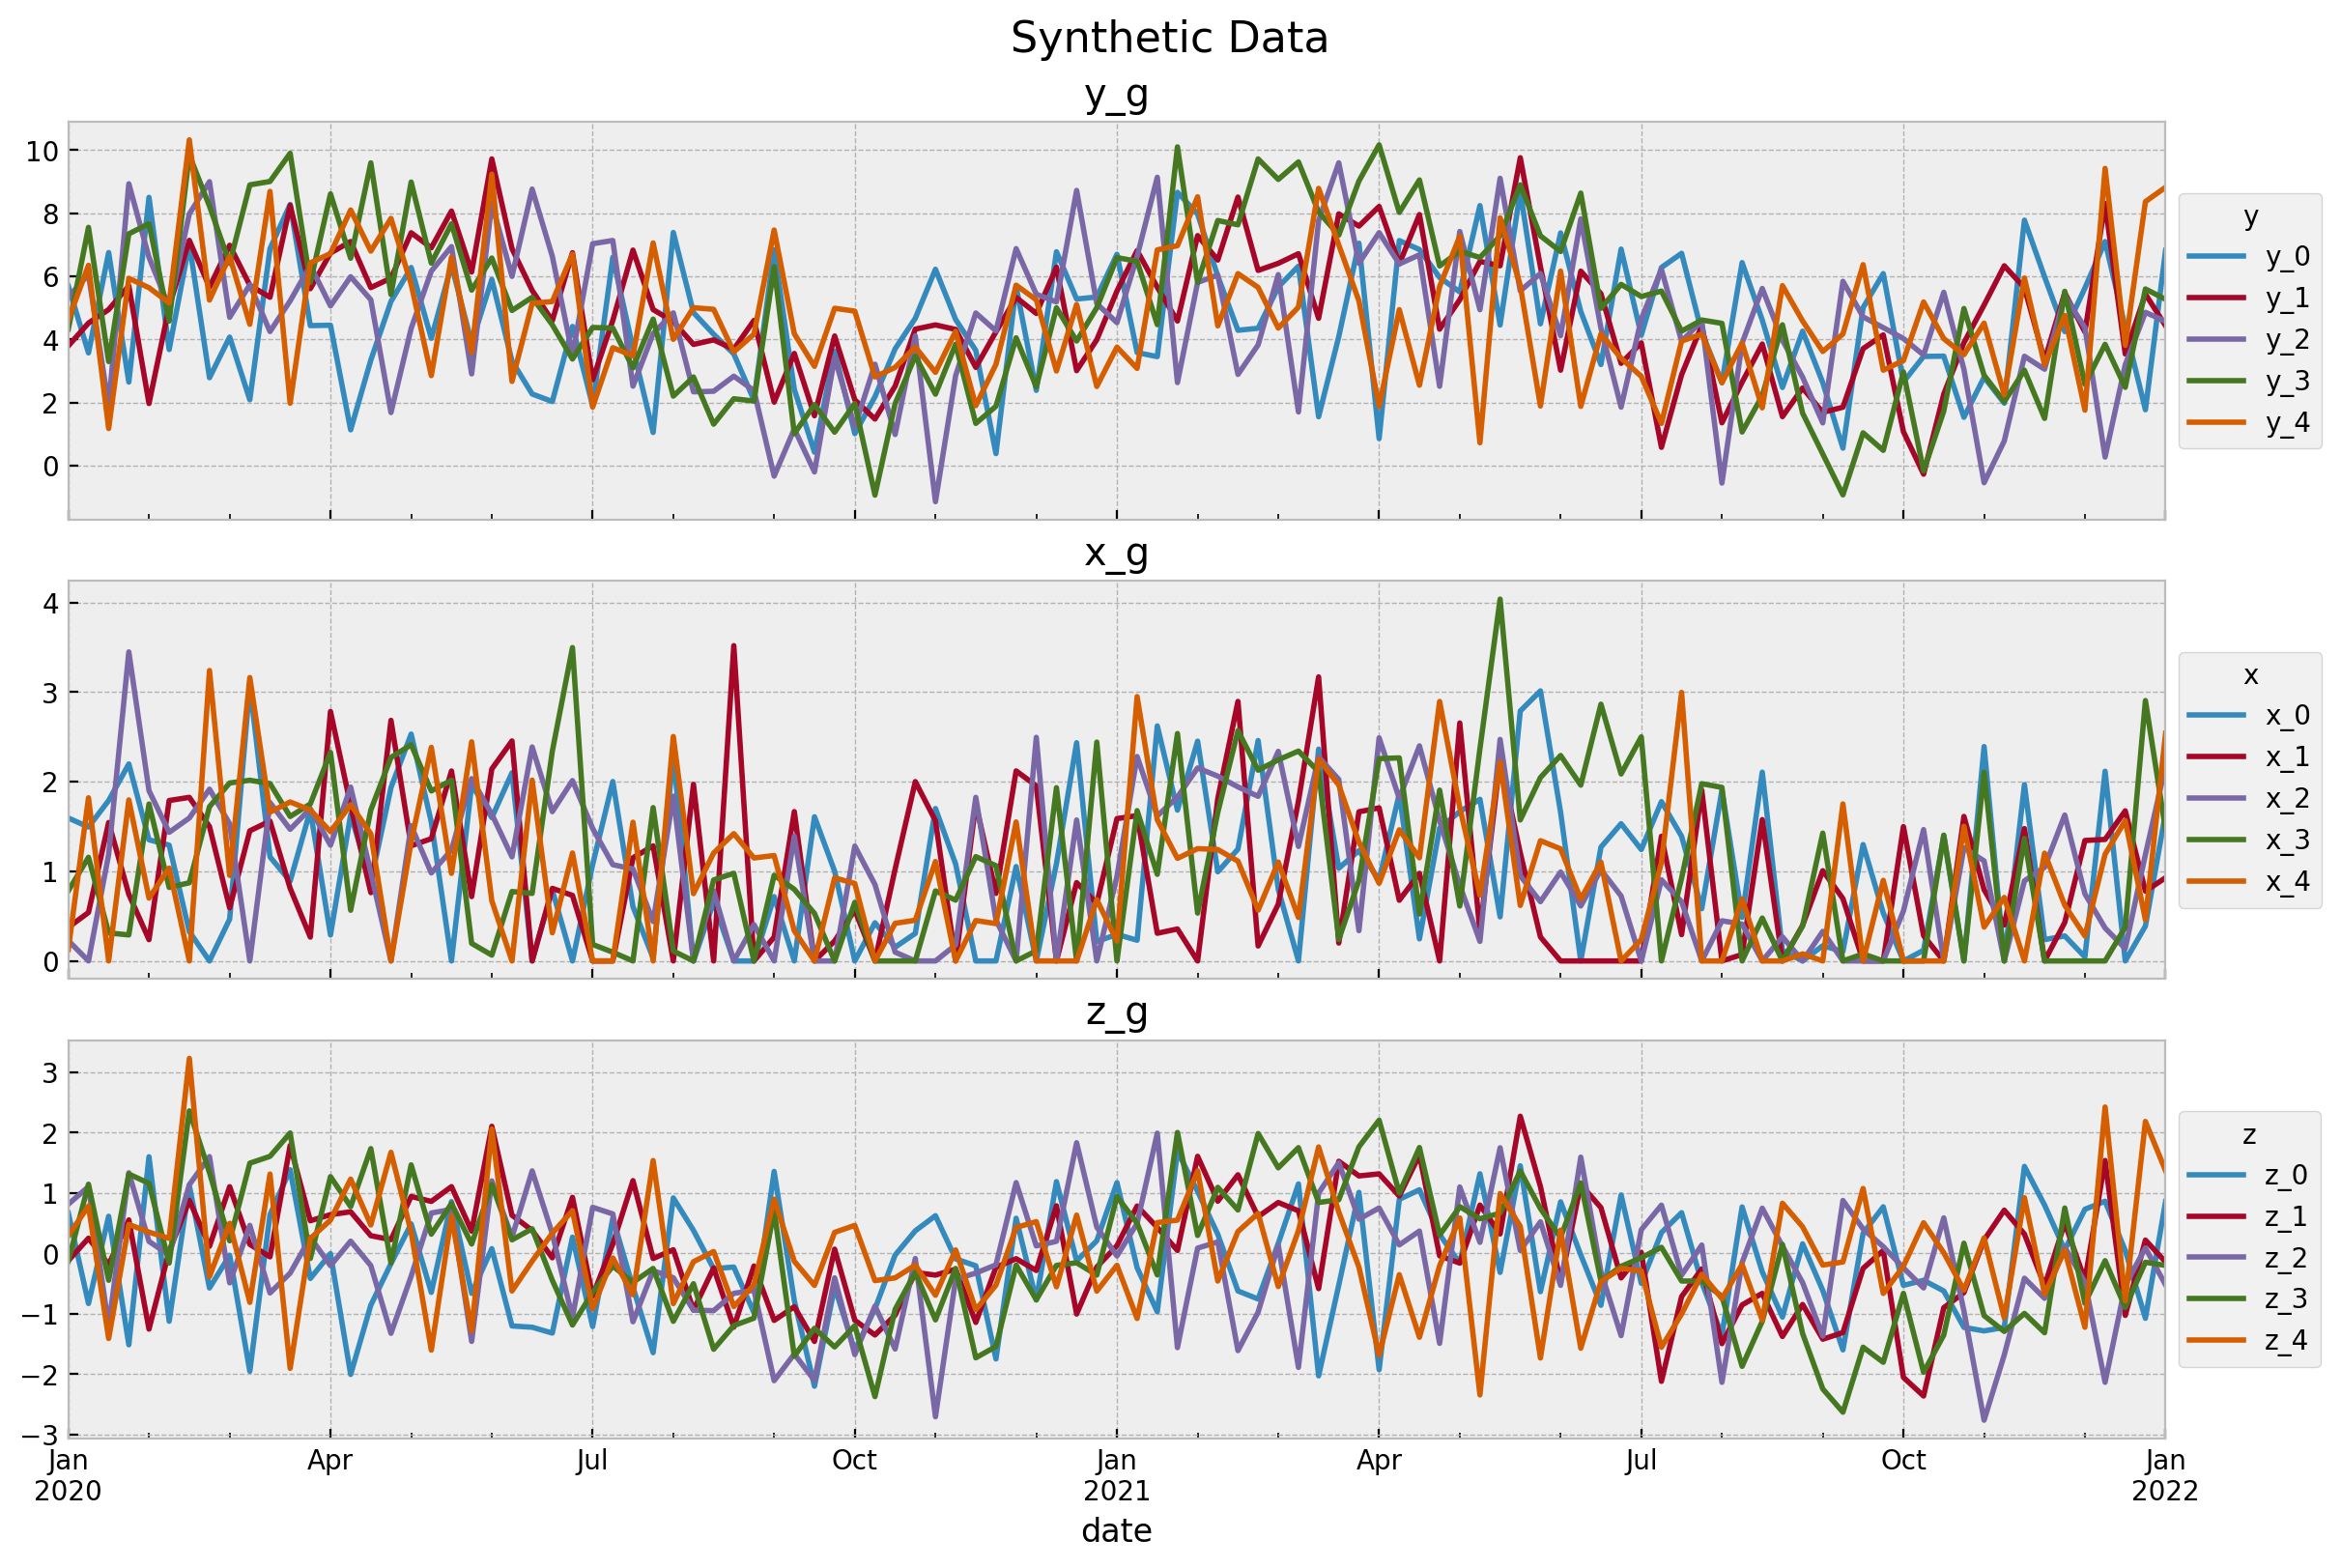

In [43]:
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
)

for i, var in enumerate(["y", "x", "z"]):
    ax = axes[i]
    wide_data_df.filter(regex=f"(date|{var}_)").set_index("date").plot(ax=ax)
    ax.legend(title=var, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set(title=f"{var}_g")

fig.suptitle("Synthetic Data", fontsize=16)

## Prepare Data

In [58]:
target_df = wide_data_df.filter(regex="y_")
channels_df = wide_data_df.filter(regex="x_")
control_df = wide_data_df.filter(regex="z_")

target_scaler = MinMaxScaler()
channels_scaler = MinMaxScaler()
control_scaler = MinMaxScaler()

target_scaler.fit(X=target_df)
scaled_target_df = pd.DataFrame(data=target_scaler.transform(X=target_df), columns=target_df.columns)

channels_scaler.fit(X=channels_df)
scaled_channels_df = pd.DataFrame(data=channels_scaler.transform(X=channels_df), columns=channels_df.columns)

control_scaler.fit(X=control_df)
scaled_control_df = pd.DataFrame(data=control_scaler.transform(X=control_df), columns=control_df.columns)

## Model

In [132]:
coords = {"date": date, "geo": range(G)}

with pm.Model(coords=coords) as model:

    # --- Priors ---

    beta = pm.Normal(name="beta", mu=0, sigma=5)
    tau = pm.Normal(name="tau", mu=0, sigma=5)
    gamma = pm.Normal(name="gamma", mu=0, sigma=5)
    eta = pm.HalfNormal(name="eta", sigma=2)
    kappa = pm.HalfNormal(name="kappa", sigma=2)
    xi = pm.HalfNormal(name="xi", sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)

    alpha = pm.Beta(name="alpha", alpha=1, beta=1)
    K = pm.Uniform(name="K", lower=0, upper=5)
    S = pm.Gamma(name="S", alpha=1.5, beta=1)

    # --- Model Parametrization ---

    ## geo-level parameters
    beta_g = pm.Normal(name="beta_g", mu=beta, sigma=eta, dims="geo")
    tau_g = pm.Normal(name="tau_g", mu=tau, sigma=kappa, dims="geo")
    gamma_g = pm.Normal(name="gamma_g", mu=gamma, sigma=xi, dims="geo")

    ## channels transformations
    # channels_adstock = pm.Deterministic(
    #     name="channels_adstock",
    #     var=geometric_adstock_vectorized(
    #         x=scaled_channels_df,
    #         alpha=alpha,
    #         l_max=4,
    #     ),
    #     dims=("date", "geo"),
    # )
    # channels_adstock_saturated = pm.Deterministic(
    #     name="channels_adstock_saturated",
    #     var=hill(x=channels_adstock, k=K, s=S),
    #     dims=("date", "geo"),
    # )
    channels_effect = pm.Deterministic(
        name="channels_effect",
        var=beta_g * scaled_channels_df,
        dims=("date", "geo"),
    )

    ## control contributions
    control_effects = pm.Deterministic(
        name="control_effects",
        var=gamma_g * scaled_control_df,
        dims=("date", "geo"),
    )

    mu_g = pm.Deterministic(
        name="mu_g", var=tau_g + channels_effect + control_effects, dims=("date", "geo")
    )
    mu = pm.Deterministic(name="mu", var=mu_g.sum(axis=1), dims="date")

    # --- Likelihood ---
    likelihood = pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, observed=scaled_target_df.sum(axis=1), dims="date"
    )

pm.model_to_graphviz(model=model)


## Prior Predictive Sampling

In [133]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1_000)

In [134]:
prior_predictive.prior_predictive

<xarray.Dataset>
Dimensions: (chain: 1, draw: 1000, date: 105)
Coordinates:
 * chain (chain) int64 0
 * draw (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
 * date (date) datetime64[ns] 2020-01-06 2020-01-13 ... 2022-01-03
Data variables:
 likelihood (chain, draw, date) float64 72.44 78.62 70.21 ... -10.58 -9.018
Attributes:
 created_at: 2022-08-31T14:56:01.851970
 arviz_version: 0.12.1
 inference_library: pymc
 inference_library_version: 4.1.7 xarray.Dataset Dimensions: chain : 1 draw : 1000 date : 105 Coordinates: (3) chain (chain) int64 0 array([0]) draw (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999 array([ 0, 1, 2, ..., 997, 998, 999]) date (date) datetime64[ns] 2020-01-06 ... 2022-01-03 array(['2020-01-06T00:00:00.000000000', '2020-01-13T00:00:00.000000000',
 '2020-01-20T00:00:00.000000000', '2020-01-27T00:00:00.000000000',
 '2020-02-03T00:00:00.000000000', '2020-02-10T00:00:00.000000000',
 '2020-02-17T00:00:00.000000000', '2020-02-24T00:00:00.000000000',
 '2020-03-02T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
 '2020-03-16T00:00:00.000000000', '2020-03-23T00:00:00.000000000',
 '2020-03-30T00:00:00.000000000', '2020-04-06T00:00:00.000000000',
 '2020-04-13T00:00:00.000000000', '2020-04-20T00:00:00.000000000',
 '2020-04-27T00:00:00.000000000', '2020-05-04T00:00:00.000000000',
 '2020-05-11T00:00:00.000000000', '2020-05-18T00:00:00.000000000',
 '2020-05-25T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
 '2020-06-08T00:00:00.000000000', '2020-06-15T00:00:00.000000000',
 '2020-06-22T00:00:00.000000000', '2020-06-29T00:00:00.000000000',
 '2020-07-06T00:00:00.000000000', '2020-07-13T00:00:00.000000000',
 '2020-07-20T00:00:00.000000000', '2020-07-27T00:00:00.000000000',
 '2020-08-03T00:00:00.000000000', '2020-08-10T00:00:00.000000000',
 '2020-08-17T00:00:00.000000000', '2020-08-24T00:00:00.000000000',
 '2020-08-31T00:00:00.000000000', '2020-09-07T00:00:00.000000000',
 '2020-09-14T00:00:00.000000000', '2020-09-21T00:00:00.000000000',
 '2020-09-28T00:00:00.000000000', '2020-10-05T00:00:00.000000000',
 '2020-10-12T00:00:00.000000000', '2020-10-19T00:00:00.000000000',
 '2020-10-26T00:00:00.000000000', '2020-11-02T00:00:00.000000000',
 '2020-11-09T00:00:00.000000000', '2020-11-16T00:00:00.000000000',
 '2020-11-23T00:00:00.000000000', '2020-11-30T00:00:00.000000000',
 '2020-12-07T00:00:00.000000000', '2020-12-14T00:00:00.000000000',
 '2020-12-21T00:00:00.000000000', '2020-12-28T00:00:00.000000000',
 '2021-01-04T00:00:00.000000000', '2021-01-11T00:00:00.000000000',
 '2021-01-18T00:00:00.000000000', '2021-01-25T00:00:00.000000000',
 '2021-02-01T00:00:00.000000000', '2021-02-08T00:00:00.000000000',
 '2021-02-15T00:00:00.000000000', '2021-02-22T00:00:00.000000000',
 '2021-03-01T00:00:00.000000000', '2021-03-08T00:00:00.000000000',
 '2021-03-15T00:00:00.000000000', '2021-03-22T00:00:00.000000000',
 '2021-03-29T00:00:00.000000000', '2021-04-05T00:00:00.000000000',
 '2021-04-12T00:00:00.000000000', '2021-04-19T00:00:00.000000000',
 '2021-04-26T00:00:00.000000000', '2021-05-03T00:00:00.000000000',
 '2021-05-10T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
 '2021-05-24T00:00:00.000000000', '2021-05-31T00:00:00.000000000',
 '2021-06-07T00:00:00.000000000', '2021-06-14T00:00:00.000000000',
 '2021-06-21T00:00:00.000000000', '2021-06-28T00:00:00.000000000',
 '2021-07-05T00:00:00.000000000', '2021-07-12T00:00:00.000000000',
 '2021-07-19T00:00:00.000000000', '2021-07-26T00:00:00.000000000',
 '2021-08-02T00:00:00.000000000', '2021-08-09T00:00:00.000000000',
 '2021-08-16T00:00:00.000000000', '2021-08-23T00:00:00.000000000',
 '2021-08-30T00:00:00.000000000', '2021-09-06T00:00:00.000000000',
 '2021-09-13T00:00:00.000000000', '2021-09-20T00:00:00.000000000',
 '2021-09-27T00:00:00.000000000', '2021-10-04T00:00:00.000000000',
 '2021-10-11T00:00:00.000000000', '2021-10-18T00:00:00.000000000',
 '2021-10-25T00:00:00.000000000', '2021-11-01T00:00:00.000000000',
 '2021-11-08T00:00:00.000000000', '2021-11-15T00:00:00.0

In [140]:
# prior_hdi = az.hdi(ary=prior_predictive.prior_predictive)["likelihood"]


# fig, axes = plt.subplots(
#     nrows=G, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
# )

# for i in range(G):
#     ax = axes[i]
#     ax.fill_between(
#         x=date, y1=prior_hdi[:, i, 0], y2=prior_hdi[:, i, 1], alpha=0.5, label="HDI"
#     )
#     ax.set(title=f"geo={i}")
#     sns.lineplot(
#         x=date,
#         y=scaled_target_df[f"y_{i}"],
#         color="black",
#         label="target(scaled)",
#         ax=ax,
#     )
#     ax.legend(title=var, loc="center left", bbox_to_anchor=(1, 0.5))

# fig.suptitle("Prior Predictive Sampling", fontsize=16)

## Fit Model

In [136]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.95, draws=6000, chains=4
    )

    posterior_predictive = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:12.323929
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time =  0:00:27.770441
Transforming variables...
Transformation time =  0:00:01.176441
Computing Log Likelihood...
Log Likelihood time =  0:00:01.378656


100.00% [24000/24000 00:03<00:00]

In [137]:
model_var_names = [
    "beta",
    "tau",
    "gamma",
    "eta",
    "xi",
    "kappa",
    "alpha",
    "K",
    "S",
    "beta_g",
    "tau_g",
    "gamma_g",
    "sigma",
]

In [138]:
az.summary(data=idata, var_names=model_var_names)

mean 
 sd 
 hdi_3% 
 hdi_97% 
 mcse_mean 
 mcse_sd 
 ess_bulk 
 ess_tail 
 r_hat 
 
 
 
 
 beta 
 0.244 
 0.025 
 0.198 
 0.291 
 0.001 
 0.000 
 2420.0 
 3921.0 
 1.0 
 
 
 tau 
 -0.087 
 0.847 
 -1.777 
 1.618 
 0.013 
 0.012 
 5178.0 
 3964.0 
 1.0 
 
 
 gamma 
 1.028 
 0.068 
 0.902 
 1.160 
 0.001 
 0.001 
 5157.0 
 4507.0 
 1.0 
 
 
 eta 
 0.033 
 0.033 
 0.000 
 0.086 
 0.001 
 0.001 
 1178.0 
 880.0 
 1.0 
 
 
 xi 
 0.122 
 0.092 
 0.001 
 0.268 
 0.002 
 0.001 
 1968.0 
 1696.0 
 1.0 
 
 
 kappa 
 1.566 
 1.182 
 0.004 
 3.679 
 0.034 
 0.024 
 1032.0 
 1293.0 
 1.0 
 
 
 alpha 
 0.501 
 0.289 
 0.058 
 0.996 
 0.003 
 0.002 
 6587.0 
 7091.0 
 1.0 
 
 
 K 
 2.495 
 1.450 
 0.058 
 4.761 
 0.017 
 0.012 
 5953.0 
 6441.0 
 1.0 
 
 
 S 
 1.492 
 1.219 
 0.002 
 3.730 
 0.013 
 0.009 
 6076.0 
 5244.0 
 1.0 
 
 
 beta_g[0] 
 0.243 
 0.024 
 0.197 
 0.290 
 0.000 
 0.000 
 3416.0 
 6221.0 
 1.0 
 
 
 beta_g[1] 
 0.229 
 0.029 
 0.173 
 0.281 
 0.001 
 0.000 
 2669.0 
 5548.0 
 1.0 
 
 
 beta_g[2] 
 0.252 
 0.028 
 0.199 
 0.307 
 0.000 
 0.000 
 3426.0 
 4531.0 
 1.0 
 
 
 beta_g[3] 
 0.240 
 0.027 
 0.188 
 0.292 
 0.000 
 0.000 
 3423.0 
 5094.0 
 1.0 
 
 
 beta_g[4] 
 0.254 
 0.026 
 0.206 
 0.306 
 0.000 
 0.000 
 3268.0 
 5596.0 
 1.0 
 
 
 tau_g[0] 
 -0.052 
 1.783 
 -3.548 
 3.458 
 0.039 
 0.035 
 3122.0 
 2471.0 
 1.0 
 
 
 tau_g[1] 
 -0.082 
 1.749 
 -3.556 
 3.473 
 0.036 
 0.028 
 3421.0 
 2711.0 
 1.0 
 
 
 tau_g[2] 
 -0.125 
 1.796 
 -3.735 
 3.392 
 0.036 
 0.028 
 3527.0 
 3111.0 
 1.0 
 
 
 tau_g[3] 
 -0.130 
 1.706 
 -3.553 
 3.179 
 0.034 
 0.028 
 3377.0 
 2542.0 
 1.0 
 
 
 tau_g[4] 
 -0.053 
 1.728 
 -3.546 
 3.641 
 0.029 
 0.025 
 4611.0 
 3343.0 
 1.0 
 
 
 gamma_g[0] 
 0.993 
 0.038 
 0.923 
 1.063 
 0.001 
 0.000 
 4181.0 
 9728.0 
 1.0 
 
 
 gamma_g[1] 
 1.037 
 0.048 
 0.948 
 1.129 
 0.001 
 0.001 
 4151.0 
 6843.0 
 1.0 
 
 
 gamma_g[2] 
 0.932 
 0.049 
 0.842 
 1.026 
 0.001 
 0.001 
 2676.0 
 2596.0 
 1.0 
 
 
 gamma_g[3] 
 1.105 
 0.054 
 1.010 
 1.209 
 0.001 
 0.001 
 2481.0 
 5452.0 
 1.0 
 
 
 gamma_g[4] 
 1.071 
 0.048 
 0.984 
 1.163 
 0.001 
 0.000 
 4910.0 
 8951.0 
 1.0 
 
 
 sigma 
 0.091 
 0.007 
 0.079 
 0.104 
 0.000 
 0.000 
 5286.0 
 7833.0 
 1.0

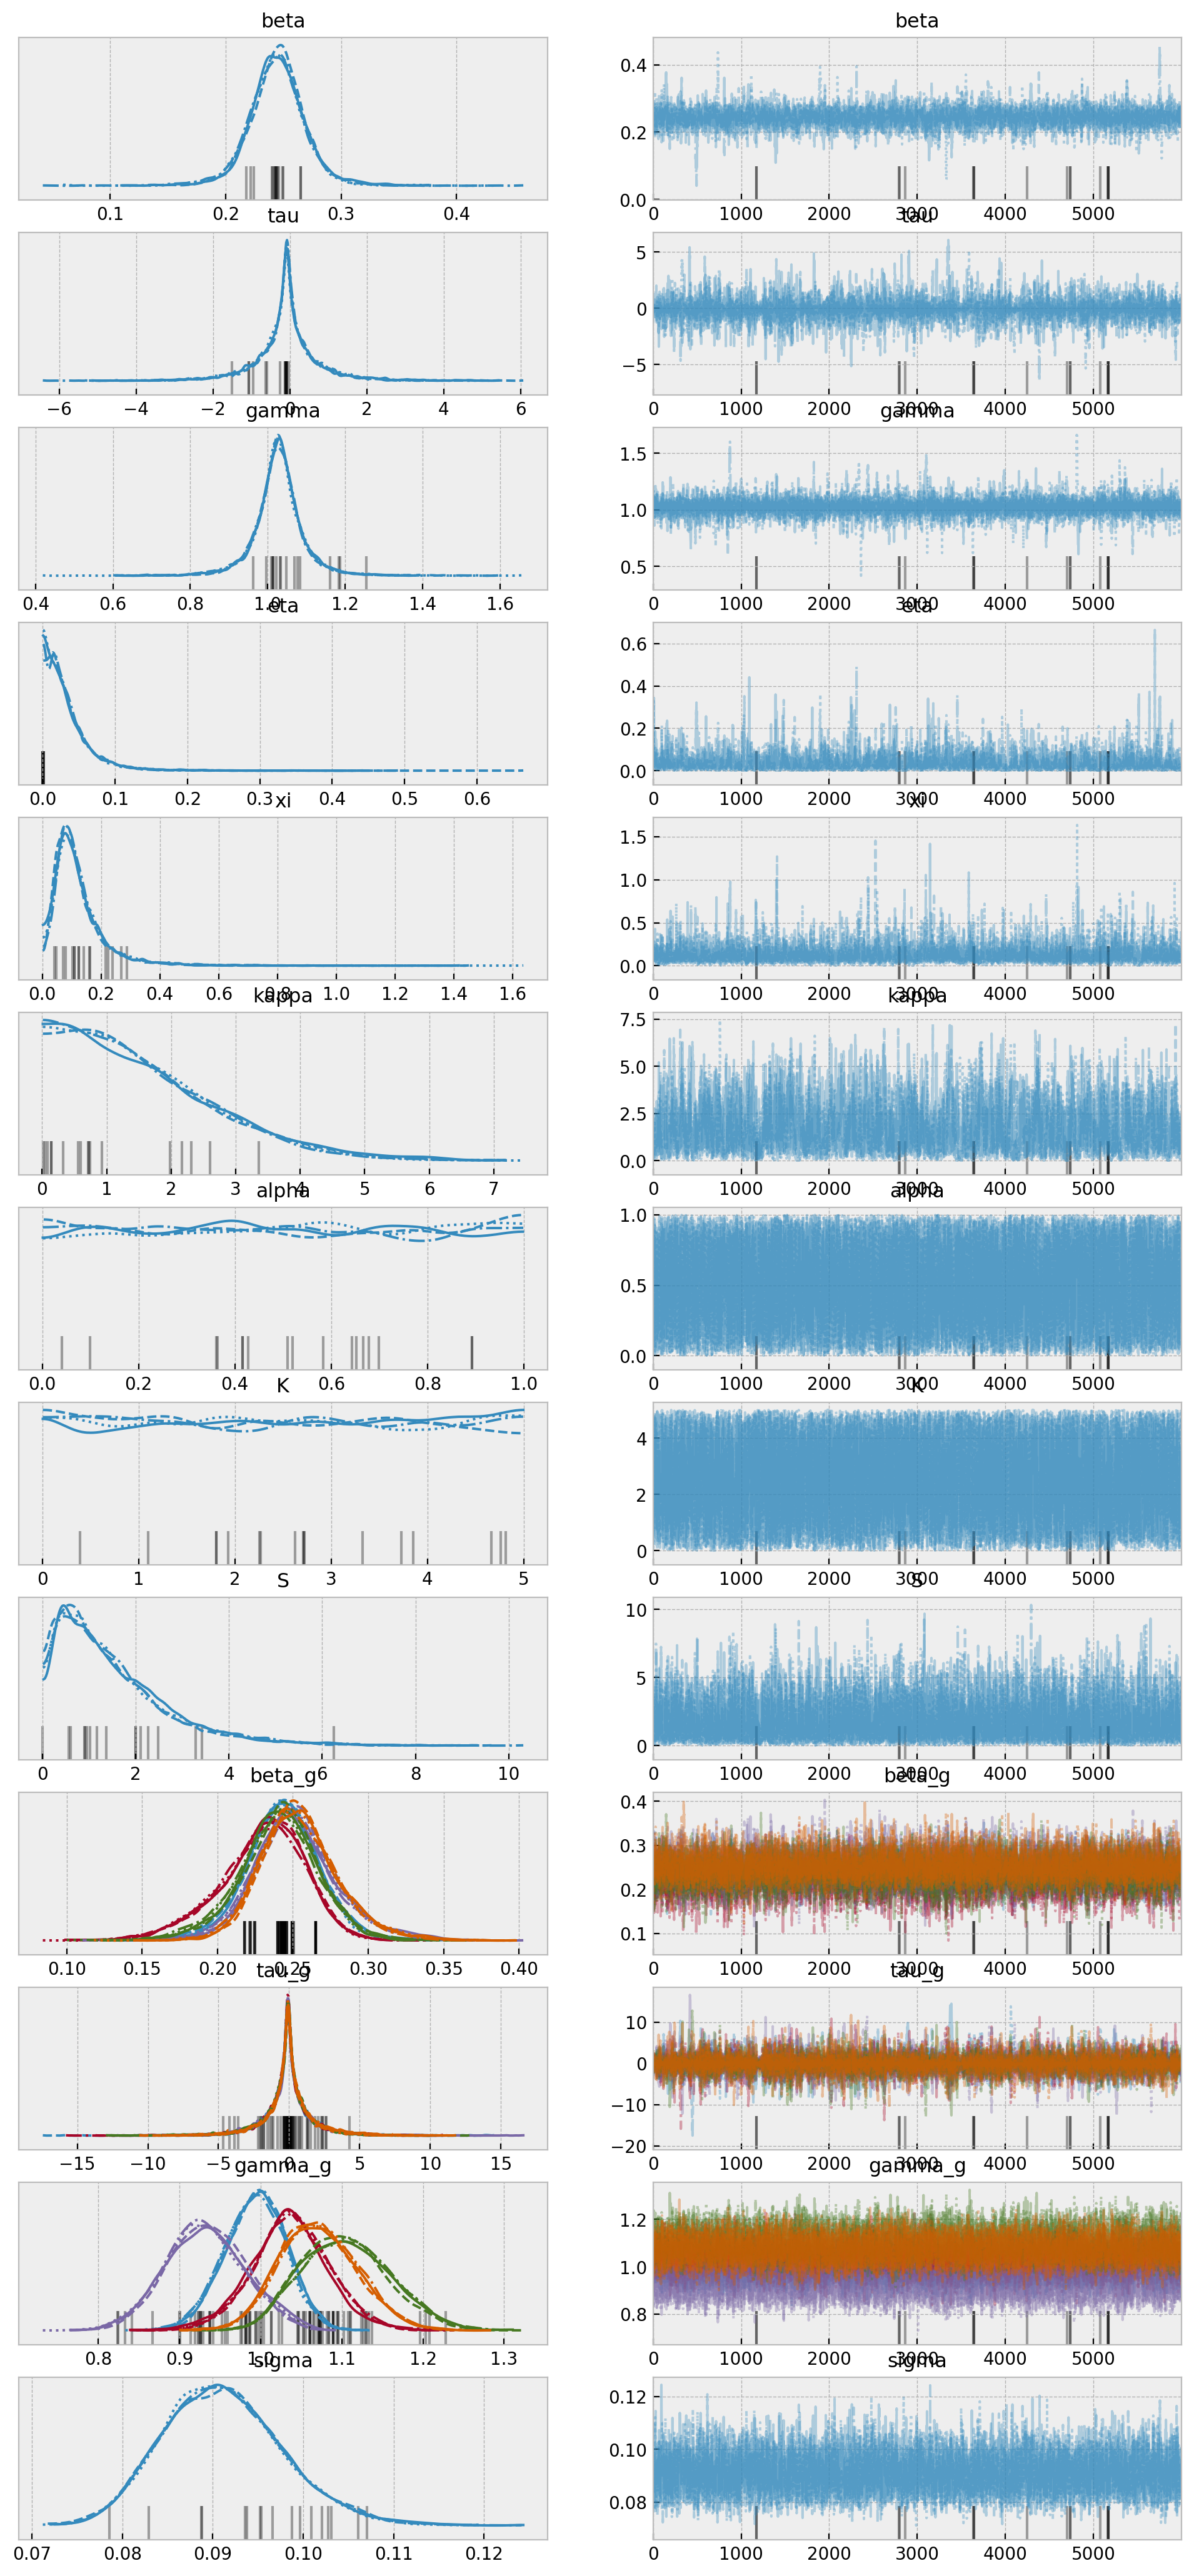

In [141]:
axes = az.plot_trace(data=idata, var_names=model_var_names)